In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import scipy as sp
import seaborn as sns
from scipy import signal
from statsmodels.tsa.stattools import adfuller

# Drinking and Mood Autocorrelation, Stationarity and Cross Correlation.

In [2]:
ema = pd.read_csv("/Users/djpassey/Data/Muri/SHINE_EMA_Round1_19May2020.csv", parse_dates=True)
ema['Notification.Time'] = pd.to_datetime(ema['Notification.Time'])
ema['Num_Alcohol'] = ema.Num_Beer + ema.Num_Wine + ema.Num_Liquor

In [3]:
MORNING = ['FirstMorning', 'Morning'] 
EVENING = ['Evening']
PVAL = 0.01

def drink_sessions(df, prompt=None):
    if prompt is None:
        ds = df[df["Session.Name"].isin(MORNING+EVENING)]
    if prompt is "morning":
        ds = df[df["Session.Name"].isin(MORNING)]
    if prompt is "evening":
        ds = df[df["Session.Name"].isin(EVENING)]    
    ds.fillna({"Num_Alcohol":0, "HadAlcohol":0})
    ds.sort_values("Notification.Time", inplace=True)
    return ds

def drink_train(idnum, df, prompt=None):
    drink_notif = df[df.ID == idnum]
    # WARNING: Fills signals with zeros if they didn't respond
    drink_notif = drink_sessions(drink_notif, prompt=prompt)
    drink_notif.sort_values("Notification.Time", inplace=True)
    times = drink_notif["Notification.Time"]
    ndrinks = drink_notif["Num_Alcohol"].fillna(0)
    return times, ndrinks.values 

def autocorr(y):
    """ Autocorrelation of a signal. Algorithm taken from:
        https://www.itl.nist.gov/div898/handbook/eda/section3/eda331.htm
    """
    mu = np.mean(y)
    N = len(y)
    auto = np.zeros(N)
    for h in range(N):
        auto[h] = np.sum((y[:N - h] - mu) * (y[h:] - mu)) / N
    var = np.sum((y - mu)**2)/N
    return auto/var

def fourier_transform(t, y):
    """ Take the fourier transform of a signal, rescale and provide a frequency array
        for easy plotting
    """
    total_time = float(t[-1] - t[0])
    N = len(y)
    xf = np.arange(N)/ (total_time)
    yf = sp.fft.fft(y) / N
    # Take half of the dfft and multiply by 2 because it is a mirror image
    yf = 2*np.abs(yf[:N//2])
    xf = xf[:N//2]
    return xf, yf

def nans_to_lines(y):
    """ This function fills in nans in time series data by find valid points
    that bookend a given series of nans, then replacing the nans with a line between the two points. 
    It also trims leading/trailing nans.
    """
    m = len(y)
    clean_y = np.zeros(m)
    nani = 0
    a = 0
    b = 0
    found_nan = False
    # Count initial nans
    initnan = 0
    if np.isnan(y[0]):
        while np.isnan(y[initnan]):
            initnan += 1
    for i in range(initnan, m):
        if np.isnan(y[i]) and not found_nan:
            a = y[i-1]
            nani = i
            found_nan = True
        if ~np.isnan(y[i]) and found_nan:
            b = y[i]
            clean_y[i] = b
            clean_y[nani:i] = np.linspace(a, b, i - nani + 2)[1:-1]
            found_nan = False
        else:
            clean_y[i] = y[i]
    return clean_y[initnan:nani] # Remove training nans    

COLORS = ["salmon", "teal", "grey", "green"]

def hist_templ(
    *data, 
    xlab="Value", 
    ylab="Frequency", 
    title="Histogram", 
    label=["Morning Prompt", "Evening Prompt"],
    bins=20,
    alpha=0.6
):
    for i, x in enumerate(data):
        plt.hist(x, bins=bins, color=COLORS[i], alpha=0.6, label=label[i])
    plt.legend()
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    p = plt.title(title)
    return p

def lines_templ(
    xdata,
    *ydata,
    xlab="Value", 
    ylab="Frequency", 
    title="Lines", 
    label=["Morning Prompt", "Evening Prompt"],
    alpha=0.6
):
    for i, y in enumerate(ydata):
        plt.plot(xdata, y, alpha=alpha, color=COLORS[i], label=label[i], lw=3)
    plt.legend()
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    p = plt.title(title)
    return p

# Extract Mood and Drinking Time Series

We separate by morning and evening prompt so that there are 24 hours between each datapoint

In [4]:
timeseries = {
    "id" : [],
    "drink.morning" : [],
    "drink.evening" : [],
    "mood.morning" : [],
    "mood.evening" : []
}

time_series_keys = ["drink.morning", "drink.evening", "mood.morning", "mood.evening"]

# Separate morning and evening prompts
morn = drink_sessions(ema, prompt="morning")
eve = drink_sessions(ema, prompt="evening")

# Participants to exclude
EXCLUDE_ID = [52927]

# Drinking and Mood data
drinkmorn = tuple()
drinkeve = tuple()
moodmorn = tuple()
moodeve = tuple()
for idnum in ema.ID.unique():
    if idnum not in EXCLUDE_ID:
        # ID numbers
        timeseries["id"].append(idnum)
        morn_id = morn[morn.ID == idnum]
        eve_id = eve[eve.ID == idnum]
        # Number of drinks time series
        drinkmorn += (morn_id["Num_Alcohol"].fillna(0).values,)
        drinkeve += (eve_id["Num_Alcohol"].fillna(0).values,)
        # Positive mood time series
        morn_m = morn_id.PositiveMood
        moodmorn += (morn_m.fillna(np.mean(morn_m)).values,)
        eve_m = eve_id.PositiveMood
        moodeve += (eve_m.fillna(np.mean(eve_m)).values,)
    
timeseries["drink.morning"] = np.vstack(drinkmorn)
timeseries["drink.evening"] = np.vstack(drinkeve)
timeseries["mood.morning"] = np.vstack(moodmorn)
timeseries["mood.evening"] = np.vstack(moodeve)

for key in time_series_keys:
    Yf = tuple()
    for ts in timeseries[key]:
        x = np.arange(28)
        xf, yf = fourier_transform(x, ts)
        Yf += (yf,)
    timeseries[key + ".ft"] = np.vstack(Yf)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


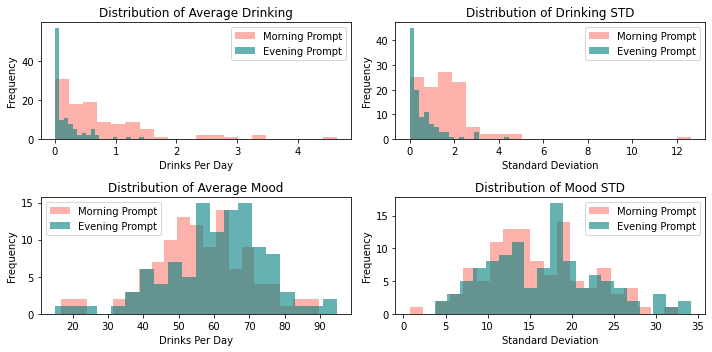

In [5]:
plt.rcParams["figure.figsize"] = [10, 5]

# Drinking Data

plt.subplot(2,2, 1) # Mean drinking
dm_mean = np.mean(timeseries["drink.morning"], axis=1)
de_mean = np.mean(timeseries["drink.evening"], axis=1)
hist_templ(dm_mean, de_mean, xlab="Drinks Per Day", title="Distribution of Average Drinking")

plt.subplot(2,2, 2) # Drinking STD
dm_mean = np.std(timeseries["drink.morning"], axis=1)
de_mean = np.std(timeseries["drink.evening"], axis=1)
hist_templ(dm_mean, de_mean, xlab="Standard Deviation", title="Distribution of Drinking STD")

# Mood Data

plt.subplot(2,2, 3) # Mean mood
dm_mean = np.mean(timeseries["mood.morning"], axis=1)
de_mean = np.mean(timeseries["mood.evening"], axis=1)
hist_templ(dm_mean, de_mean, xlab="Drinks Per Day", title="Distribution of Average Mood")

plt.subplot(2,2, 4) # Mood std
dm_mean = np.std(timeseries["mood.morning"], axis=1)
de_mean = np.std(timeseries["mood.evening"], axis=1)
hist_templ(dm_mean, de_mean, xlab="Standard Deviation", title="Distribution of Mood STD")

plt.tight_layout()
plt.show()

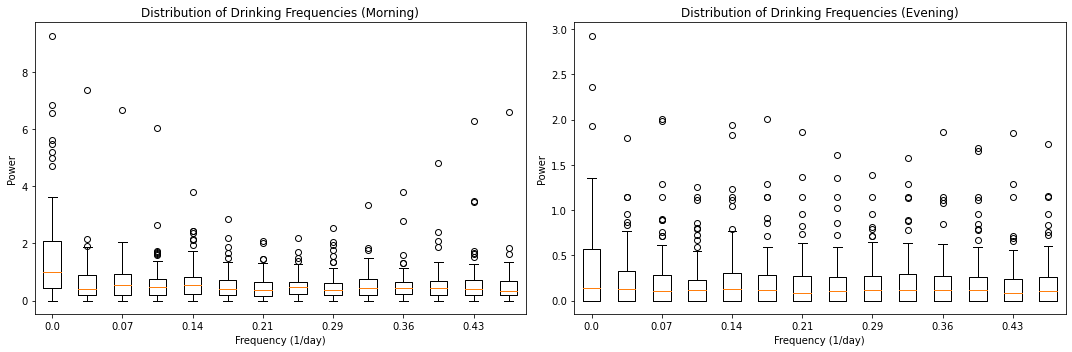

In [6]:
plt.rcParams["figure.figsize"] = [15, 5]

# Frequency axis (For fourier transform)
total_time = 28.0
N = 28
xf = np.arange(N)/ (total_time)
xf = xf[:N//2]

# Drinking Data

plt.subplot(1, 2, 1) # Fourier transform morning
plt.boxplot(timeseries["drink.morning.ft"])
plt.xticks(np.arange(1,15,2), np.round(xf[::2],2))
plt.title("Distribution of Drinking Frequencies (Morning)")
plt.ylabel("Power")
#plt.ylim(-.1, 2.50)
plt.xlabel("Frequency (1/day)")

plt.subplot(1, 2, 2) # Fourier transform evening
plt.boxplot(timeseries["drink.evening.ft"])
plt.xticks(np.arange(1,15,2), np.round(xf[::2],2))
plt.title("Distribution of Drinking Frequencies (Evening)")
plt.ylabel("Power")
#plt.ylim(-.1, 2.50)
plt.xlabel("Frequency (1/day)")
plt.tight_layout()
plt.show()

## Distribution at Each Frequency

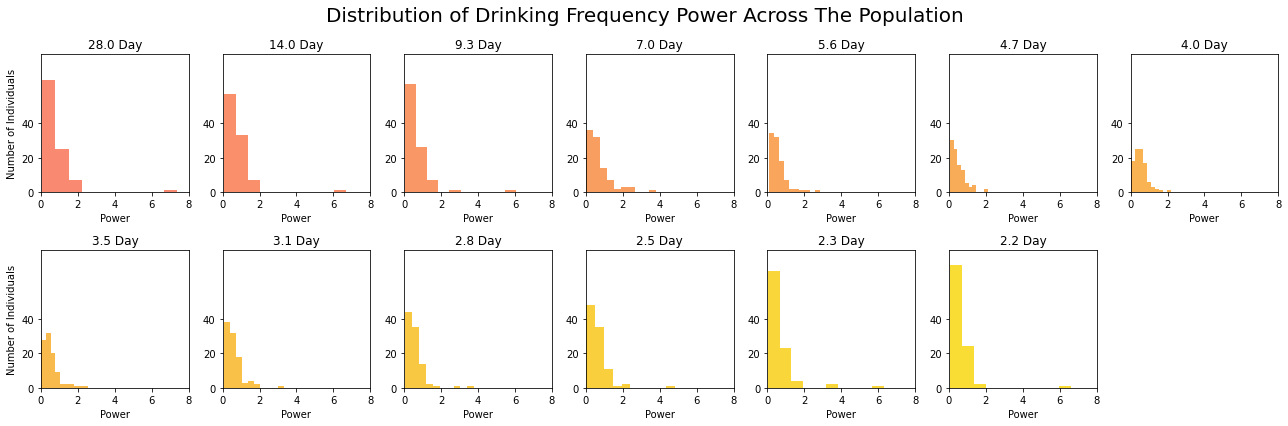

In [11]:
plt.rcParams["figure.figsize"] = [18, 6]

salmon = np.array([250,131,117]) / 256
# Lets do a gradient 
color_grad_step = np.array([0, 7, -5]) / 256
drinker_idx = np.where(np.mean(timeseries["drink.morning"], axis=1) != 0)[0]
drinkers = timeseries["drink.morning.ft"][drinker_idx, :]
cols = drinkers.shape[1]

for j in range(1, cols):
    plt.subplot(2,7,j)
    freq_dist = drinkers[:, j]
    plt.hist(freq_dist, color=salmon + j*color_grad_step)
    plt.xlim(0,8)
    plt.ylim(0, 80)
    #plt.xticks([0.25])
    plt.yticks([0, 20, 40])
    plt.title(f"{round(1/xf[j],1)} Day")
    if j % 7 == 1:
        plt.ylabel("Number of Individuals")
    plt.xlabel("Power")
    
plt.suptitle("Distribution of Drinking Frequency Power Across The Population", fontsize=20)
plt.tight_layout()
plt.show()

Fourier transform analysis of each drinking time series in the population. Frequency information is extracted from individual drinking timeseries and gives information about the relative importance of different oscillatory periods in the individual's time series. For example, we hypothesize that a seven day cycle should be an important component of a drinking timeseries, given the prevalence of drinking each weekend. Each plot shows the distribution of the importance of the specified frequency across the population. For example, the upper left plot shows the distribution of the importance of a 28 day cycle across the population and the lower right plot shows the distribution of a 2.2 day cycle across the population. Shorter cycles are plotted in lighter colors.

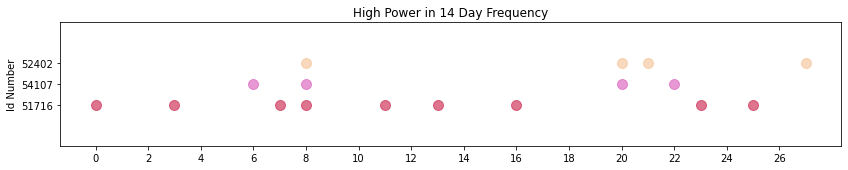

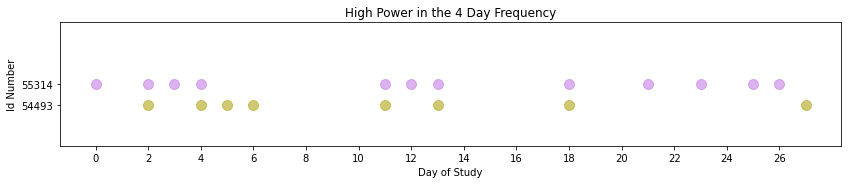

In [21]:
plt.rcParams["figure.figsize"] = [14, 5]

plt.subplot(2,1,1)
low_freq = np.where(timeseries["drink.morning.ft"][:, 2] > .4)[0][:3]
idnum = 0
for i in low_freq:
    drinks = timeseries["drink.morning"][i, :]
    times = np.where(drinks > 0)[0]
    plt.scatter(times, idnum*np.ones(len(times)), s=100, alpha=0.6, c=np.random.rand(1,3))
    idnum += 1

plt.ylim(-2,4)
plt.yticks([0, 1, 2], [timeseries["id"][int(idx)] for idx in low_freq])
plt.ylabel("Id Number")
plt.title("High Power in 14 Day Frequency")
plt.xticks(np.arange(0,28,2))
plt.show()

plt.subplot(2,1,2)
high_freq = np.where(timeseries["drink.morning.ft"][:, 7] > 1.5)[0]
idnum = 0
for i in high_freq:
    drinks = timeseries["drink.morning"][i, :]
    times = np.where(drinks > 0)[0]
    plt.scatter(times, idnum*np.ones(len(times)), s=100, alpha=0.6, c=np.random.rand(1,3))
    idnum += 1

plt.ylim(-2,4)
plt.yticks(range(len(high_freq)), [timeseries["id"][int(idx)] for idx in high_freq])
plt.ylabel("Id Number")
plt.title("High Power in the 4 Day Frequency")
plt.xlabel("Day of Study")
plt.xticks(np.arange(0,28,2))

plt.show()

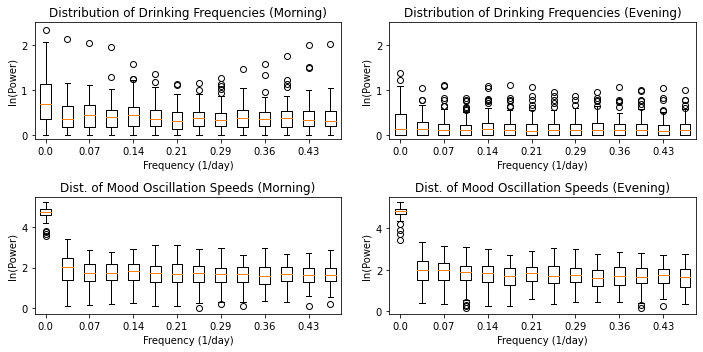

In [6]:
plt.rcParams["figure.figsize"] = [10, 5]

# Frequency axis (For fourier transform)
total_time = 28.0
N = 28
xf = np.arange(N)/ (total_time)
xf = xf[:N//2]

# Drinking Data

plt.subplot(2, 2, 1) # Fourier transform morning
plt.boxplot(np.log(timeseries["drink.morning.ft"] + 1))
plt.xticks(np.arange(1,15,2), np.round(xf[::2],2))
plt.title("Distribution of Drinking Frequencies (Morning)")
plt.ylabel("ln(Power)")
plt.ylim(-.1, 2.50)
plt.xlabel("Frequency (1/day)")

plt.subplot(2, 2, 2) # Fourier transform evening
plt.boxplot(np.log(timeseries["drink.evening.ft"] + 1))
plt.xticks(np.arange(1,15,2), np.round(xf[::2],2))
plt.title("Distribution of Drinking Frequencies (Evening)")
plt.ylabel("ln(Power)")
plt.ylim(-.1, 2.50)
plt.xlabel("Frequency (1/day)")

# Mood data

plt.subplot(2, 2, 3) # Fourier transform morning
plt.boxplot(np.log(timeseries["mood.morning.ft"] + 1))
plt.xticks(np.arange(1,15,2), np.round(xf[::2],2))
plt.title("Dist. of Mood Oscillation Speeds (Morning)")
plt.ylabel("ln(Power)")
#plt.ylim(-.1, 2.50)
plt.xlabel("Frequency (1/day)")

plt.subplot(2, 2, 4) # Fourier transform evening
plt.boxplot(np.log(timeseries["mood.evening.ft"] + 1))
plt.xticks(np.arange(1,15,2), np.round(xf[::2],2))
plt.title("Dist. of Mood Oscillation Speeds (Evening)")
plt.ylabel("ln(Power)")
#plt.ylim(-.1, 2.50)
plt.xlabel("Frequency (1/day)")

plt.tight_layout()
plt.show()

In [ ]:
for key in time_series_keys:
    ts = timeseries[key]
    pvals = [adfuller(x)[1] for x in ts]
    timeseries[key + ".adfuller"] = np.array(pvals)

Note: Remove higher frequencies and see what happens to the cross-correlations
Remove the amount of drinking. And just do if drink
Mood is not lagged, drinking is lagged

# Stationarity of Drinking

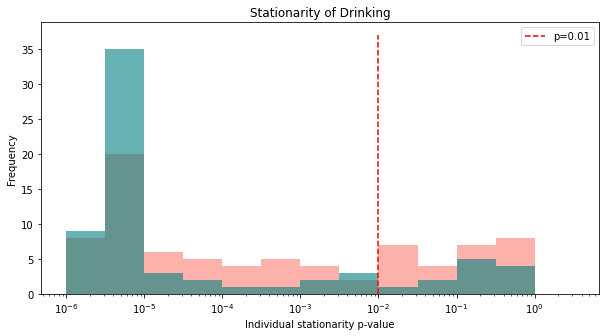

72 / 108 Participants show stationarity in drinking (Morning)
67 / 108 Participants show stationarity in drinking (Evening)


In [8]:

bins = 10**(np.arange(-6.0, 1, 0.5))
dmp = timeseries["drink.morning.adfuller"]
dep = timeseries["drink.evening.adfuller"]
plt.xscale('log')
plt.hist(dmp, bins=bins, color=COLORS[0], alpha=0.6)
plt.hist(dep, bins=bins, color=COLORS[1], alpha=0.6)
plt.plot(np.ones(38)*PVAL, np.arange(0,38), "--", c="r", label=f"p={PVAL}")
plt.xlabel("Individual stationarity p-value")
plt.ylabel("Frequency")
plt.title("Stationarity of Drinking")
plt.legend()
plt.show()

adf_sig = lambda x: np.sum(x < PVAL)
print(f"{adf_sig(dmp)} / 108 Participants show stationarity in drinking (Morning)")
print(f"{adf_sig(dep)} / 108 Participants show stationarity in drinking (Evening)")

# Stationarity of Mood

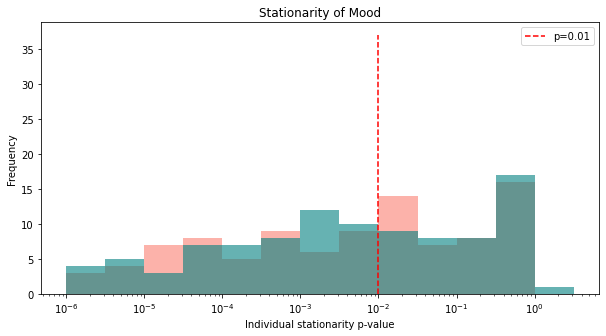

63 / 108 Participants show stationarity in mood (Morning)
65 / 108 Participants show stationarity in mood (Evening)


In [10]:
bins = 10**(np.arange(-6.0, 1, 0.5))
mmp = timeseries["mood.morning.adfuller"]
mep = timeseries["mood.evening.adfuller"]

plt.xscale('log')
plt.hist(mmp, bins=bins, color=COLORS[0], alpha=0.6)
plt.hist(mep, bins=bins, color=COLORS[1], alpha=0.6)
plt.title("Stationarity of Mood")
plt.xlabel("Individual stationarity p-value")
plt.ylabel("Frequency")
plt.plot(np.ones(38)*PVAL, np.arange(0,38), "--", c="r", label=f"p={PVAL}")
plt.legend()
plt.show()

print(f"{adf_sig(mmp)} / 108 Participants show stationarity in mood (Morning)")
print(f"{adf_sig(mep)} / 108 Participants show stationarity in mood (Evening)")

How many were stationary in mood, drinking, both, just one or the other? (In a table)

# Autocorrelation of Drinking

In [43]:
def crosscorr(x, y):
    w = x - np.mean(x)
    z = y - np.mean(y)
    cc = signal.correlate(w, z)
    cc /= np.max(np.abs(cc))
    return cc
    
def autocorr(x):
    return crosscorr(x, x)

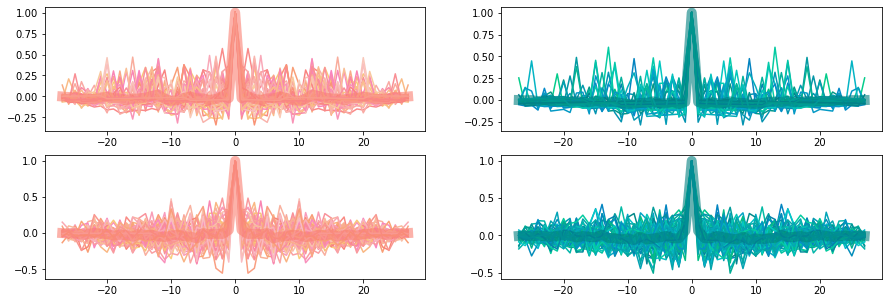

In [47]:
plt.rcParams["figure.figsize"] = [15, 5]
lags = np.arange(-27, 28)

plt.subplot(2,2,1)
mu_mm_ac = np.zeros(55)
n = 0
salmon = np.array([250,131,117]) / 256
for x, p in zip(timeseries["drink.morning"], timeseries["drink.morning.adfuller"]):
    
    if p < 0.01:
        ac = autocorr(x)
        mu_mm_ac += ac
        n +=1
        jitter = np.random.rand(3) * 0.3
        jitter[0] = 0
        plt.plot(lags, ac, c=salmon + jitter)
plt.plot(lags, mu_mm_ac/n, lw=10, alpha=0.6, c="salmon")

plt.subplot(2,2,2)
mu_em_ac = np.zeros(55)
n = 0
teal = np.array([4,128,128]) / 256
for x, p in zip(timeseries["drink.evening"], timeseries["drink.evening.adfuller"]):
    
    if p < 0.01:
        ac = autocorr(x)
        mu_em_ac += ac
        n +=1
        jitter = np.random.rand(3) * 0.3
        jitter[0] = 0
        plt.plot(lags, ac, c=teal + jitter)
plt.plot(lags, mu_em_ac/n, lw=10, alpha=0.6, c="teal")

plt.subplot(2,2,3)
mu_mm_ac = np.zeros(55)
n = 0
salmon = np.array([250,131,117]) / 256
for x, p in zip(timeseries["mood.morning"], timeseries["mood.morning.adfuller"]):
    
    if p < 0.01:
        ac = autocorr(x)
        mu_mm_ac += ac
        n +=1
        jitter = np.random.rand(3) * 0.3
        jitter[0] = 0
        plt.plot(lags, ac, c=salmon + jitter)
plt.plot(lags, mu_mm_ac/n, lw=10, alpha=0.6, c="salmon")

plt.subplot(2,2,4)
mu_em_ac = np.zeros(55)
n = 0
teal = np.array([4,128,128]) / 256
for x, p in zip(timeseries["mood.evening"], timeseries["mood.evening.adfuller"]):
    
    if p < 0.01:
        ac = autocorr(x)
        mu_em_ac += ac
        n +=1
        jitter = np.random.rand(3) * 0.3
        jitter[0] = 0
        plt.plot(lags, ac, c=teal + jitter)
plt.plot(lags, mu_em_ac/n, lw=10, alpha=0.6, c="teal")

plt.show()

## Cross Correlation of Mood and Drinking

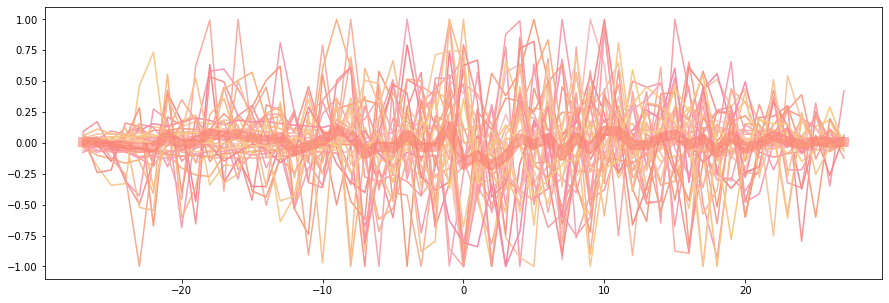

In [49]:
mu_cc = np.zeros(55)
n = 0

for m, mp, d, dp in zip(timeseries["mood.morning"], timeseries["mood.morning.adfuller"], timeseries["drink.morning"], timeseries["drink.morning.adfuller"]):
    
    if (mp < 0.01) and (dp < 0.01):
        cc = crosscorr(m, d)
        mu_cc += cc
        n +=1
        jitter = np.random.rand(3) * 0.3
        jitter[0] = 0
        plt.plot(lags, cc, c=salmon + jitter)
plt.plot(lags, mu_cc/n, lw=10, alpha=0.6, c="salmon")

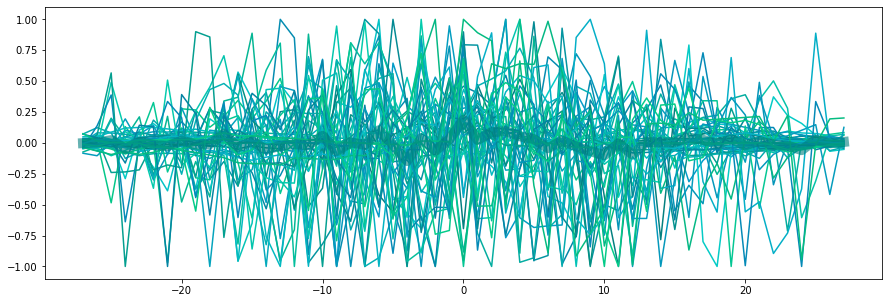

In [52]:
mu_cc = np.zeros(55)
n = 0

for m, mp, d, dp in zip(timeseries["mood.evening"], timeseries["mood.evening.adfuller"], timeseries["drink.evening"], timeseries["drink.evening.adfuller"]):
    
    if (mp < 0.01) and (dp < 0.01):
        cc = crosscorr(m, d)
        mu_cc += cc
        n +=1
        jitter = np.random.rand(3) * 0.3
        jitter[0] = 0
        plt.plot(lags, cc, c=teal + jitter)
plt.plot(lags, mu_cc/n, lw=10, alpha=0.6, c="teal")